In [4]:
#%%

import os
import logging
# 配置 logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# os.chdir(os.path.dirname(__file__))
import numpy as np
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR
import pandas as pd

# set path and type

In [5]:
#%% Data generation Y->X
# 读取数据
args ='anhui'
# 获取省份名称首字母大写形式
province_cap = args.capitalize()
# 读取数据
emission_data = pd.read_csv('dataset/total_monthly_state_emission.csv')
selected_columns = emission_data[['num', 'date']].copy()  # 使用列名选择
selected_columns[province_cap] = emission_data[province_cap]  # 添加省份列
# 更新emission_data
emission_data = selected_columns
vehicle_data = pd.read_csv(f'dataset/car/result_{args}.csv')  
df_col = {
    'emission': 0,
    'EVER': 1,
    'PHEV': 2,
    'FUEL': 3,
    'EV': 4
}
fuel_col_idx = df_col['EVER']
emission_col_idx = df_col['emission']

# 数据集划分比例
train_percent = 0.6
val_percent = 0
test_percent = 0.4

# 数据日期清洗和准备
emission_data['date'] = emission_data['date'].astype(str)
vehicle_data['date'] = vehicle_data['date'].astype(str)
emission_data['date'] = pd.to_datetime(emission_data['date'], format='%B %Y')  
# vehicle_data['date'] = pd.to_datetime(vehicle_data['date'], format='%Y/%m/%d')
emission_data['date'] = emission_data['date'].dt.strftime('%Y-%m-%d')
# vehicle_data['date'] = vehicle_data['date'].dt.strftime('%Y-%m-%d')

# 选取时间范围
start_date = '2022-06-01'
end_date = '2024-09-01'
vehicle_data_mask = (vehicle_data['date'] >= start_date) & (vehicle_data['date'] <= end_date)
emission_data_mask = (emission_data['date'] >= start_date) & (emission_data['date'] <= end_date)

emission_data = emission_data.loc[emission_data_mask]
vehicle_data = vehicle_data.loc[vehicle_data_mask]

# 丢掉第一列
emission_data = emission_data.drop(emission_data.columns[[0]], axis=1)

# 数据对齐
emission_data.set_index('date', inplace=True)
vehicle_data.set_index('date', inplace=True)
vehicle_data_grouped = vehicle_data.groupby('date').sum()
merged_data = pd.merge(emission_data, vehicle_data_grouped, on='date', how='inner')
merged_data = merged_data.drop(merged_data.columns[[1]], axis=1)
merged_data

,Anhui,MPV,SUV,medium_car,med_large_car,large_car,small_car,micro_car,compact_car,roadster,...,150-300w,300-1000w,joint_type,self_owned_type,imported_type,joint_brand,state_owned_brand,international_brand,self_owned_brand,new_force_brand
date,,,,,,,,,,,,,,,,,,,,,
2022-06-01,34.809514,3559.0,26456.0,10253.0,3436.0,175.0,1600.0,5520.0,17836.0,41.0,...,98.0,0.0,37285.0,30248.0,1343.0,27903.0,3084.0,14399.0,20943.0,2547.0
2022-07-01,38.540280,2187.0,17433.0,7069.0,2297.0,101.0,1292.0,3436.0,11689.0,24.0,...,117.0,0.0,24659.0,19898.0,971.0,17860.0,2208.0,9972.0,13568.0,1920.0
2022-08-01,41.149139,3689.0,25466.0,10318.0,3231.0,230.0,1643.0,4925.0,18024.0,60.0,...,227.0,0.0,37112.0,29049.0,1425.0,26936.0,3349.0,14885.0,20063.0,2353.0
2022-09-01,33.011258,4245.0,26660.0,9324.0,3148.0,140.0,1689.0,4697.0,17691.0,46.0,...,194.0,0.0,35481.0,30644.0,1515.0,26712.0,3336.0,13729.0,21415.0,2448.0
2022-10-01,33.251411,3522.0,27135.0,10778.0,3288.0,179.0,1852.0,4875.0,18245.0,36.0,...,160.0,0.0,37912.0,30628.0,1370.0,27647.0,3424.0,15086.0,21054.0,2699.0
2022-11-01,32.326106,3306.0,26278.0,11090.0,3616.0,146.0,1854.0,4995.0,17081.0,27.0,...,138.0,0.0,36568.0,30425.0,1400.0,26498.0,3203.0,14852.0,20942.0,2898.0
2022-12-01,36.015482,3390.0,26896.0,10905.0,3244.0,232.0,1651.0,4990.0,18050.0,29.0,...,184.0,0.0,37533.0,30214.0,1640.0,27117.0,3293.0,15609.0,20170.0,3198.0
2023-01-01,32.817612,3624.0,26389.0,10201.0,3402.0,143.0,1743.0,5642.0,17312.0,33.0,...,139.0,0.0,36972.0,30310.0,1207.0,27341.0,3140.0,14287.0,20727.0,2994.0
2023-02-01,30.508653,3287.0,26387.0,10950.0,3290.0,164.0,1439.0,5682.0,19410.0,46.0,...,122.0,0.0,38571.0,30844.0,1240.0,28034.0,3137.0,15222.0,21117.0,3145.0


2024-12-25 15:17:34,645 - root - DEBUG - [[-2.75679273e-01  2.58471080e-01 -1.30978493e-01 -1.47208376e-01
   1.29627165e-01 -1.19146611e-01 -5.13300140e-01  3.83918037e-01
   1.61587111e-01  2.21206640e-01 -1.10695865e+00 -7.57693182e-01
   2.87249803e-01  9.54684036e-01 -2.16903436e+00  4.39086790e-01
   9.95886150e-03  2.96611991e-02  5.23968901e-01  5.76222363e-01
  -6.08301009e-01 -1.10910123e+00 -3.55479381e-01 -3.38975110e-01
  -5.85403787e-02 -1.59959118e+00  0.00000000e+00  2.71991090e-01
  -1.92855001e-01 -5.90868784e-01  5.32796397e-01 -5.64145850e-01
  -2.59460044e-01  3.12130518e-01 -1.07608735e+00]
 [ 9.88560478e-01 -3.98306033e+00 -4.54722437e+00 -4.08596020e+00
  -3.25064229e+00 -1.70165800e+00 -2.59351650e+00 -3.50201176e+00
  -4.63684754e+00 -1.07872374e+00 -1.23023596e+00 -3.09022828e+00
  -4.77983672e+00 -3.70160916e+00 -3.92150997e-01 -4.59872893e+00
  -4.71445973e+00 -4.16312525e+00 -4.32173884e+00 -2.32604059e+00
  -2.65888820e+00 -2.90226293e+00 -2.95898469e+00 

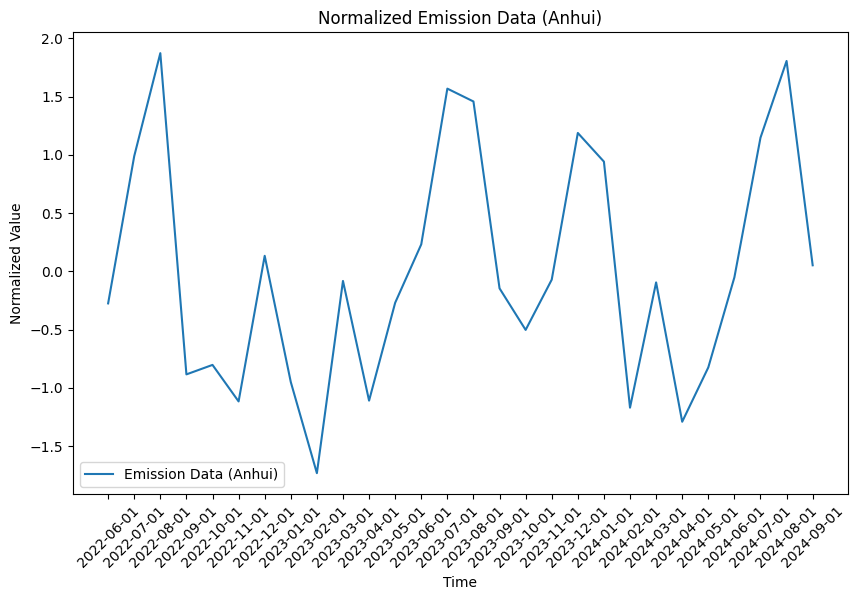

2024-12-25 15:17:34,832 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-25 15:17:34,834 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-25 15:17:34,836 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-25 15:17:34,838 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-25 15:17:34,

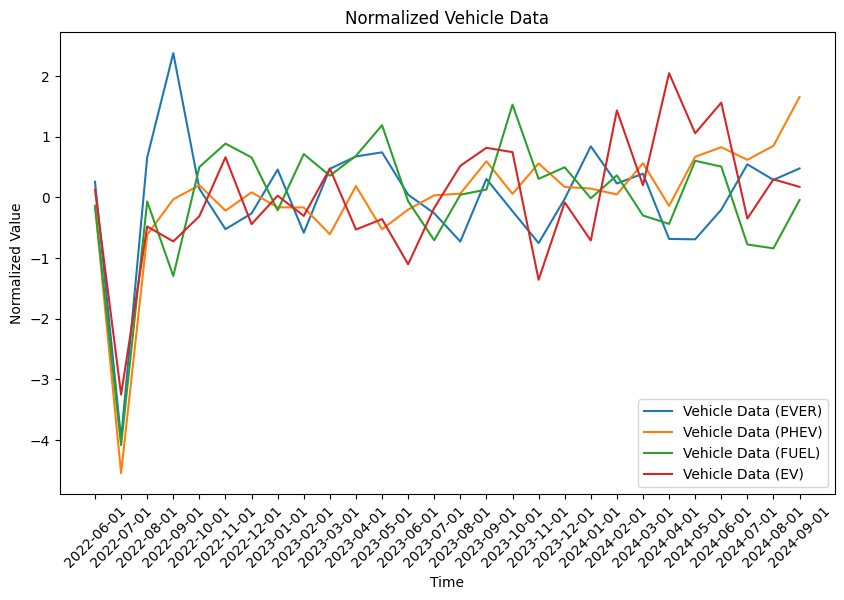

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# 创建归一化器
scaler = StandardScaler()

# 归一化数据
'''
FIXME: 一起做归一化之后出现大量极值
'''
merged_data_n = scaler.fit_transform(merged_data)
# emission_data_n = scaler.fit_transform(merged_data.iloc[:, [0]])
# vehicle_data_n = scaler.fit_transform(merged_data.iloc[:, 1:])
logging.debug(merged_data_n)
# logging.debug(emission_data_n)
# logging.debug(vehicle_data_n)

# 绘制图形
plt.figure(figsize=(10, 6))
# 绘制 emission_data
plt.plot(merged_data.index, merged_data_n[:, 0], label='Emission Data (Anhui)')
# 添加标题和标签
plt.title('Normalized Emission Data (Anhui)')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
# 旋转 x 轴标签
plt.xticks(rotation=45)
# 显示图形
plt.show()

# 绘制图形
plt.figure(figsize=(10, 6))
# 绘制 vehicle_data
plt.plot(merged_data.index, merged_data_n[:, 1], label='Vehicle Data (EVER)')
plt.plot(merged_data.index, merged_data_n[:, 2], label='Vehicle Data (PHEV)')
plt.plot(merged_data.index, merged_data_n[:, 3], label='Vehicle Data (FUEL)')
plt.plot(merged_data.index, merged_data_n[:, 4], label='Vehicle Data (EV)')
# 添加标题和标签
plt.title('Normalized Vehicle Data')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
# 旋转 x 轴标签
plt.xticks(rotation=45)
# 显示图形
plt.show()


# tune parameter

1/1 [==============================] - 0s 12ms/step
Statistics value = 48.0 p-value = 0.0185546875


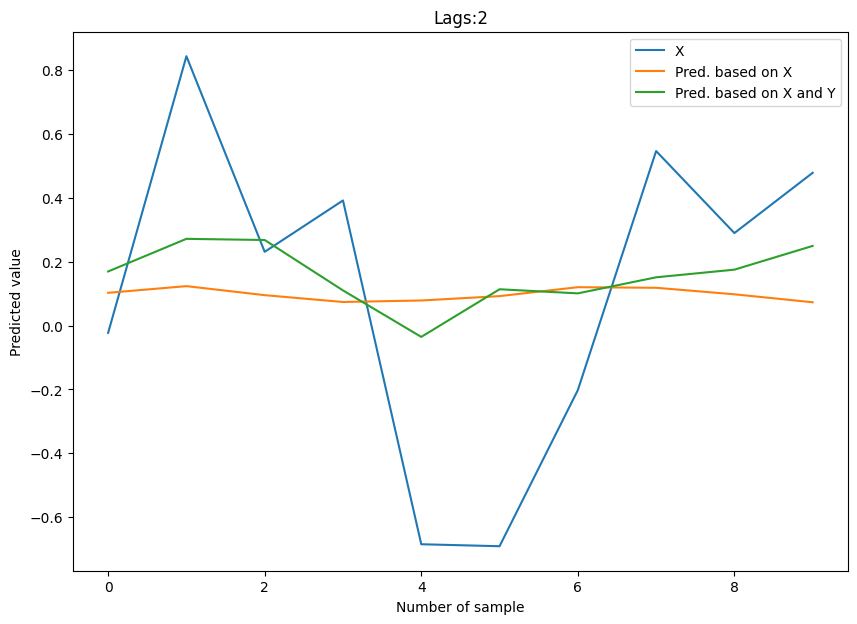

For lag = 2 Cohen's d = 0.135
Test statistic = 48.0 p-value = 0.0185546875
1/1 [==============================] - 0s 12ms/step


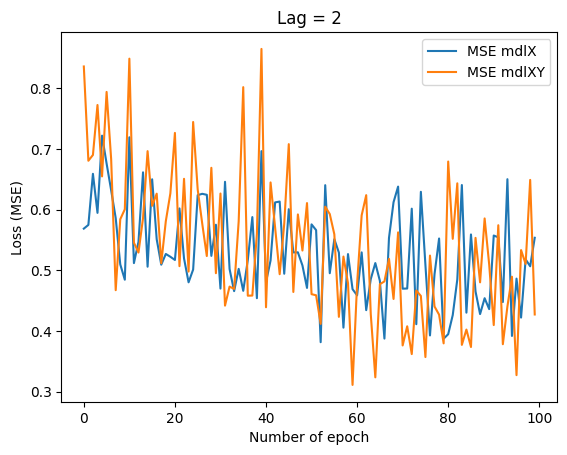

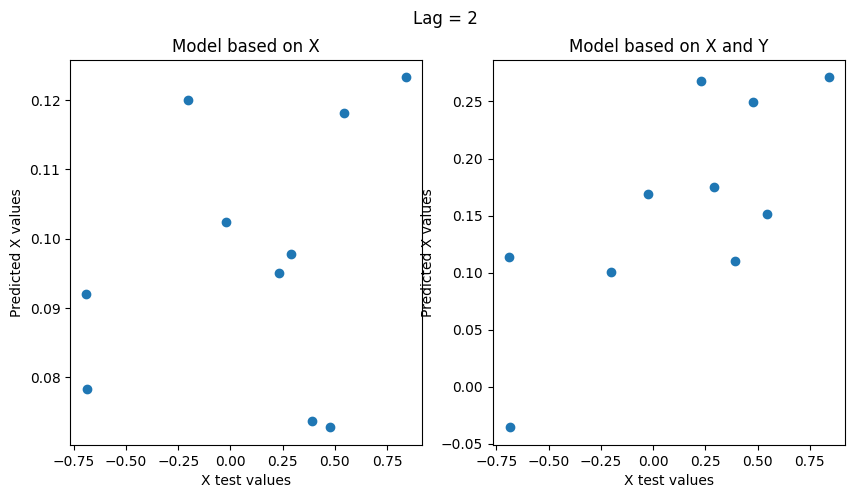

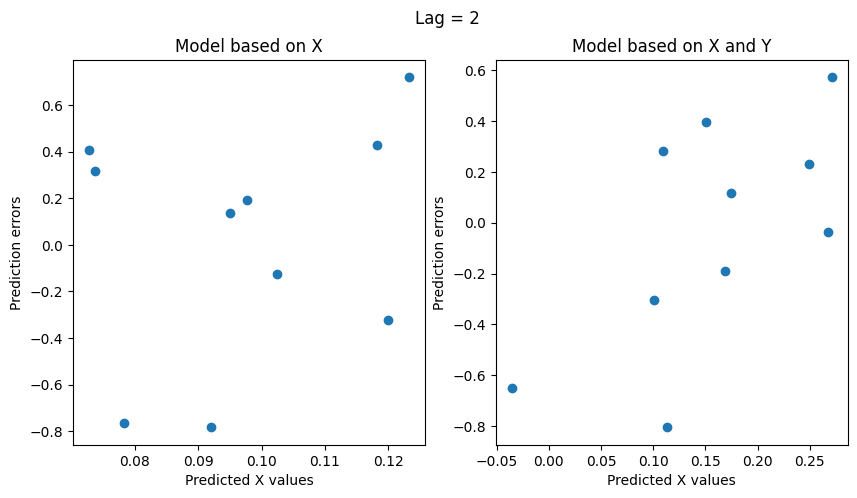

In [18]:
#%% Test in case of presence of the causality
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 60%-train, 20%-validation, 20%-test
# 确保比例之和为1
assert train_percent + val_percent + test_percent == 1, "划分比例之和必须为1"

# 计算索引
total = len(merged_data_n)
train_end = int(total * train_percent)
val_end = int(train_end) + round(total * val_percent)
# switch emission and vehicle data, X is vehicle data, Y is emission data

data_train = merged_data_n[:train_end, [fuel_col_idx, emission_col_idx]]
data_val = merged_data_n[train_end:val_end, [fuel_col_idx, emission_col_idx]]
data_test = merged_data_n[val_end:, [fuel_col_idx, emission_col_idx]]
# logging.debug(data_train)



add={'n_units_0': 24, 'dropout_1': 0.3, 'run': 3, 'epochs_1': 70, 'epochs_2': 30, 'lr_1': 0.00020511104188433984, 'lr_2': 1.3066739238053272e-05, 'batch_size': 16, 'regularization': 'None'}

lags = [2]

nonlincausalityNN_params = {
    'x': data_train,
    'maxlag': lags,
    'NN_config': ['g', 'dr'],
    'NN_neurons': [add['n_units_0'], add['dropout_1']],
    'x_test': data_test,
    'run': add['run'],
    'epochs_num': [add['epochs_1'], add['epochs_2']],
    'learning_rate': [add['lr_1'], add['lr_2']],
    'batch_size_num': add['batch_size'],
    'x_val':data_val,
    'regularization': add['regularization'],
    'reg_alpha': None,#add['reg_alpha_1'],
    'callbacks':None,
    'verbose':False,
    'plot':True
}
nonlincausalityARIMA_params = {
    'x': data_train,
    'maxlag': lags,
    'x_test': data_test,
    'plot':True
}
results = nlc.nonlincausalityNN(**nonlincausalityNN_params)
# results = nlc.nonlincausalityARIMA(**nonlincausalityARIMA_params)

#%% Example of obtaining the results

for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

# RUN

In [ ]:
'''
run!!!!!
'''
logging.debug("run!!!!")

For lag = 3 Cohen's d = 0.116
Test statistic = 4.0 p-value = 0.375
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


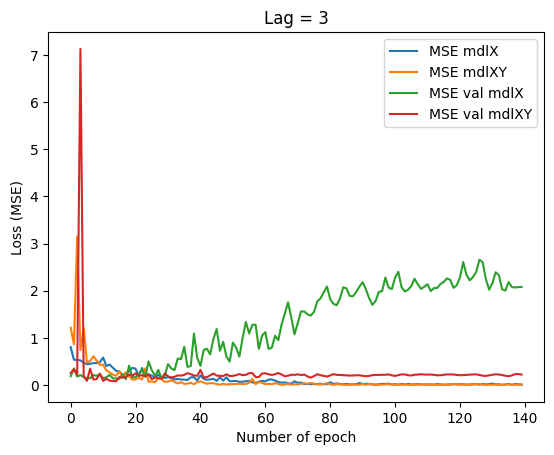

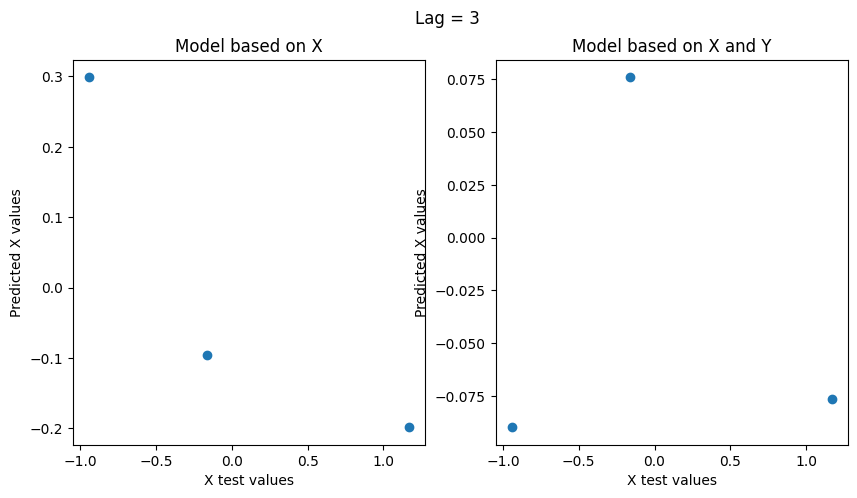

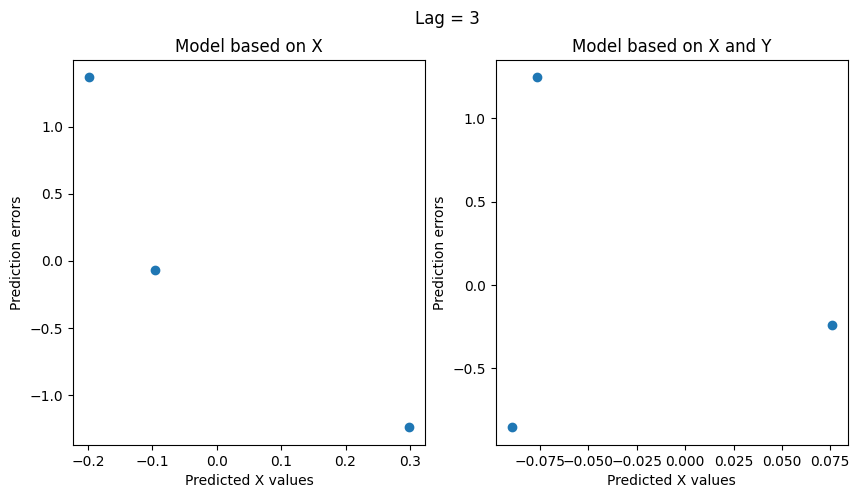

In [70]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

# RUN ME

In [ ]:
'''
run!!!!!
'''
logging.debug("run!!!!")

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

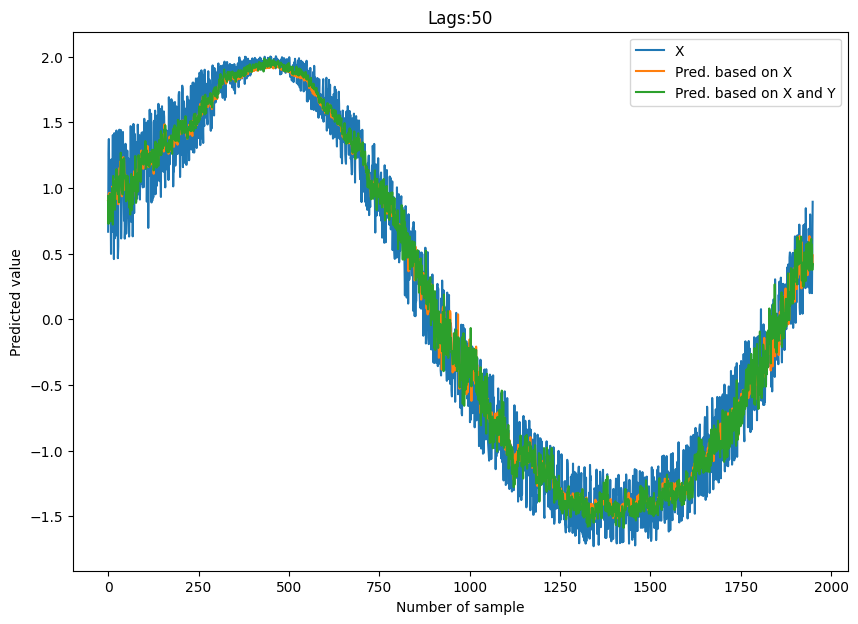

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

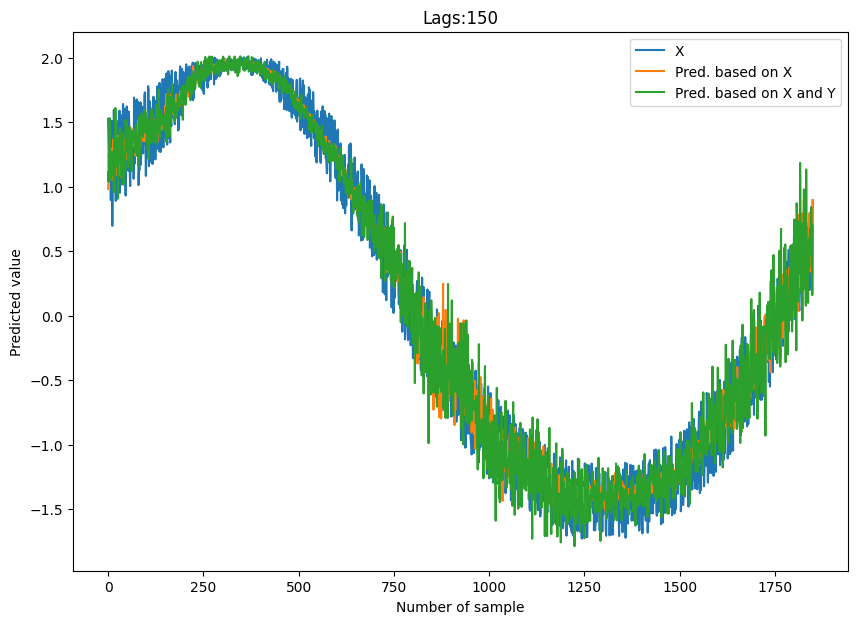

In [ ]:
#%% Test in case of absence of the causality

np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

For lag = 50 Cohen's d = 0.029
test statistic = 886494.0 p-value = 0.995318875558966
For lag = 150 Cohen's d = 0.113
test statistic = 676264.5 p-value = 0.9999999999999974


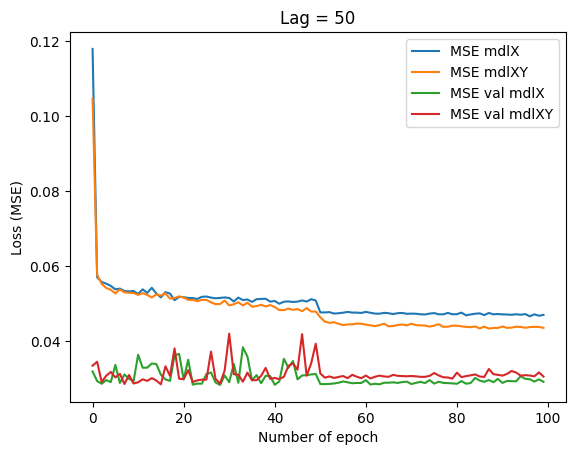

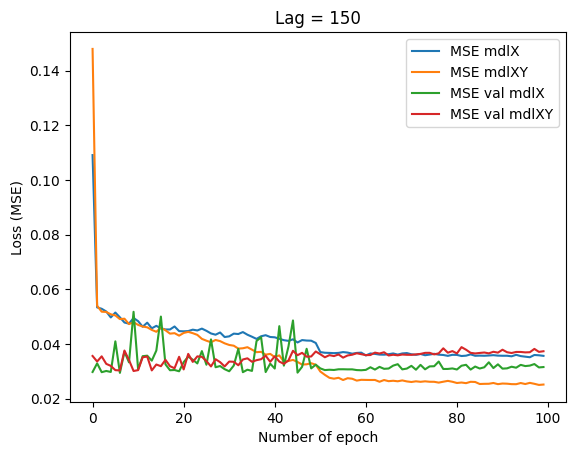

In [ ]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")

0->1
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3388 - mse: 0.3388 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0604 - mse: 0.0604 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - los

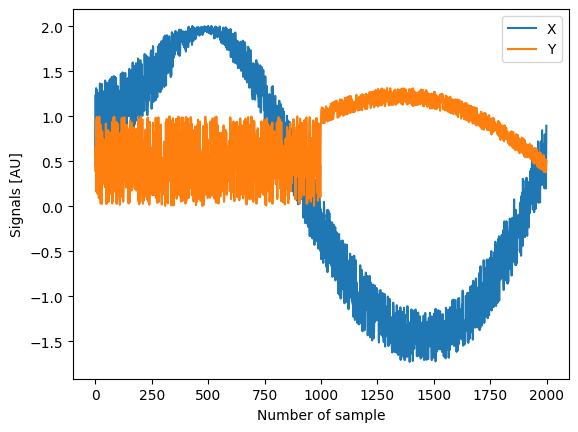

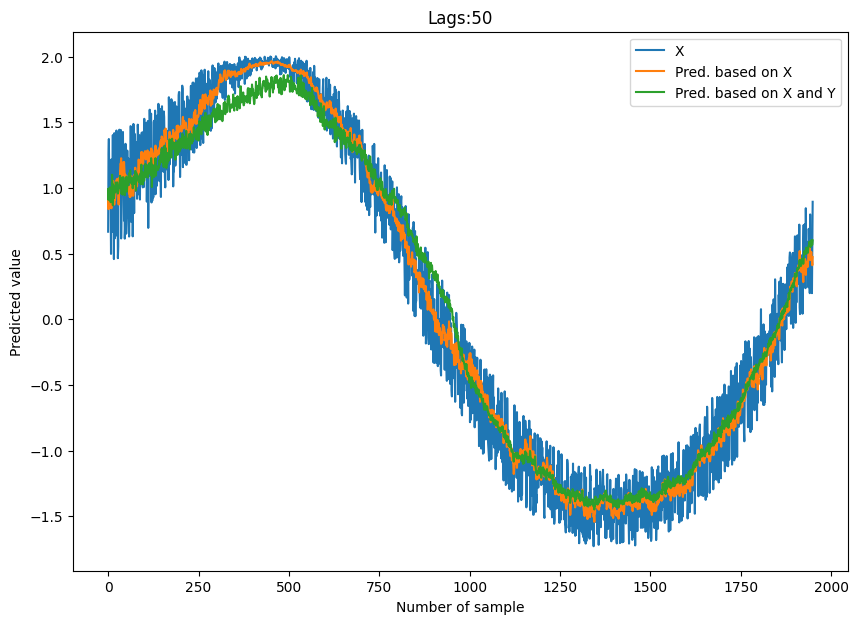

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2324 - mse: 0.2324 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

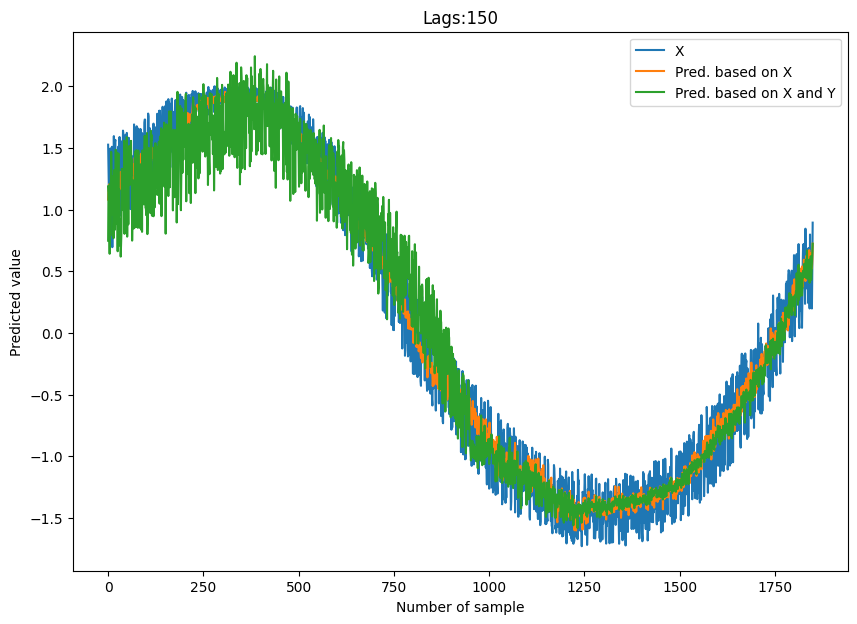

58/58 [==============================] - 0s 2ms/step
1->0
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186

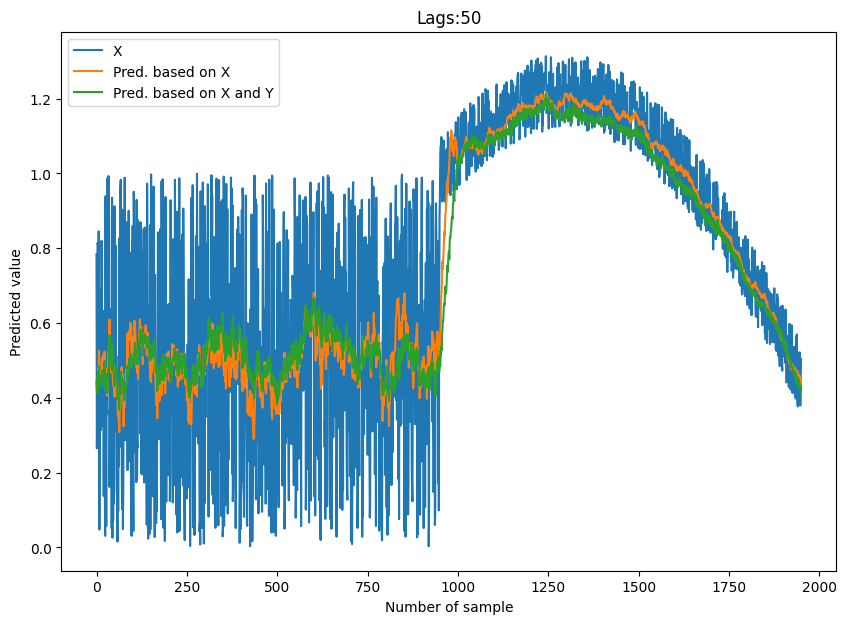

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

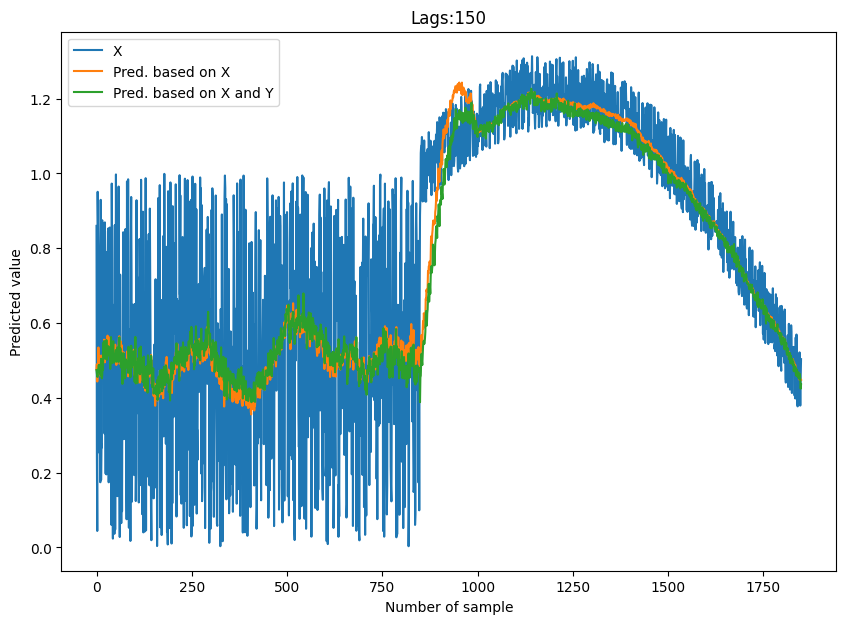

58/58 [==============================] - 0s 2ms/step


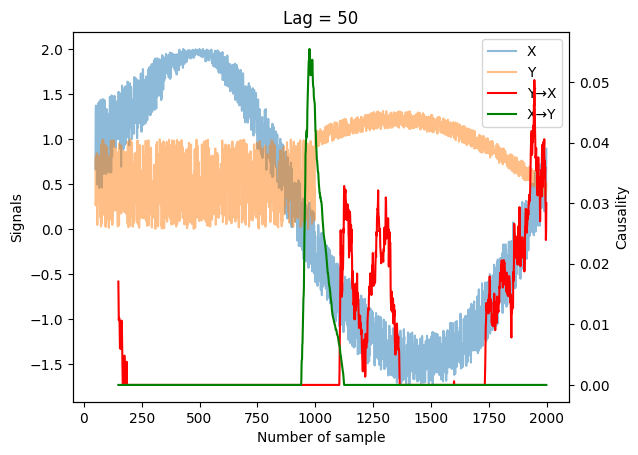

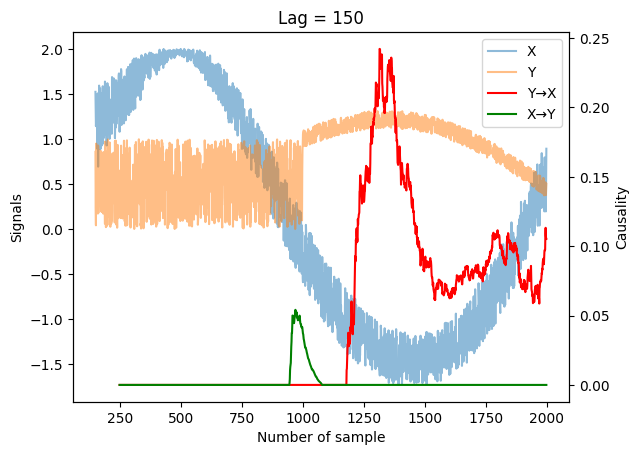

In [ ]:
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3035 - mse: 0.3035 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

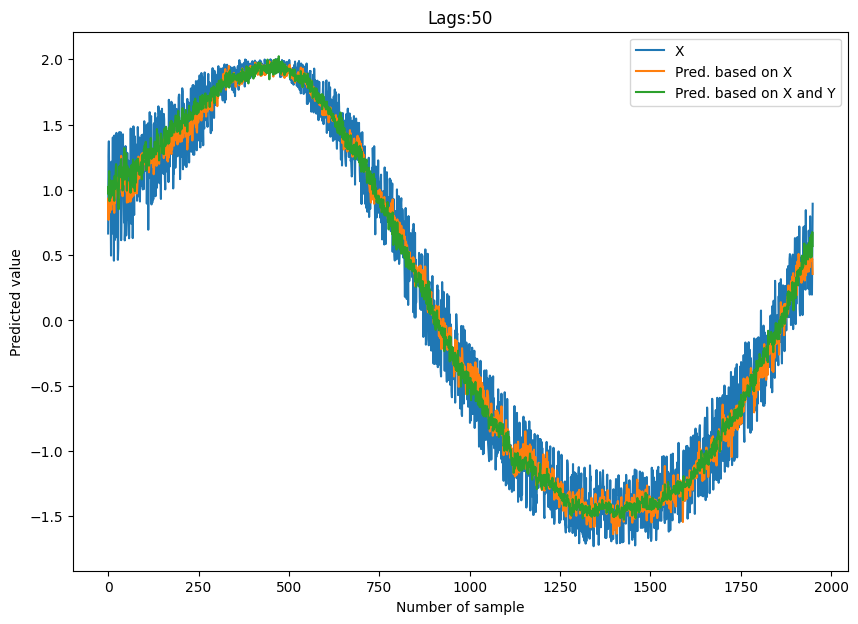

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

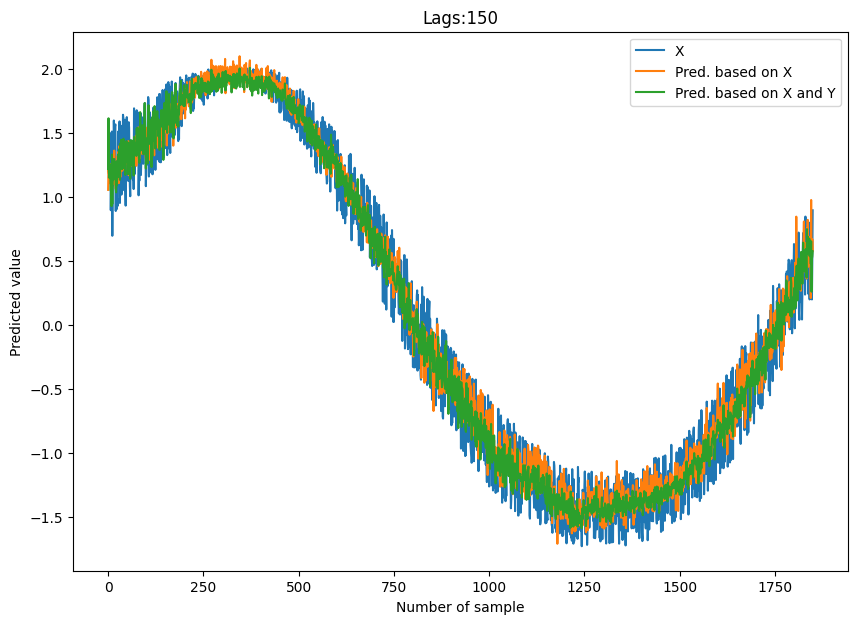

In [ ]:
#%% Example of usage for conditional analysis

np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

Statistics value = 1042424.0 p-value = 0.00012035170468659112


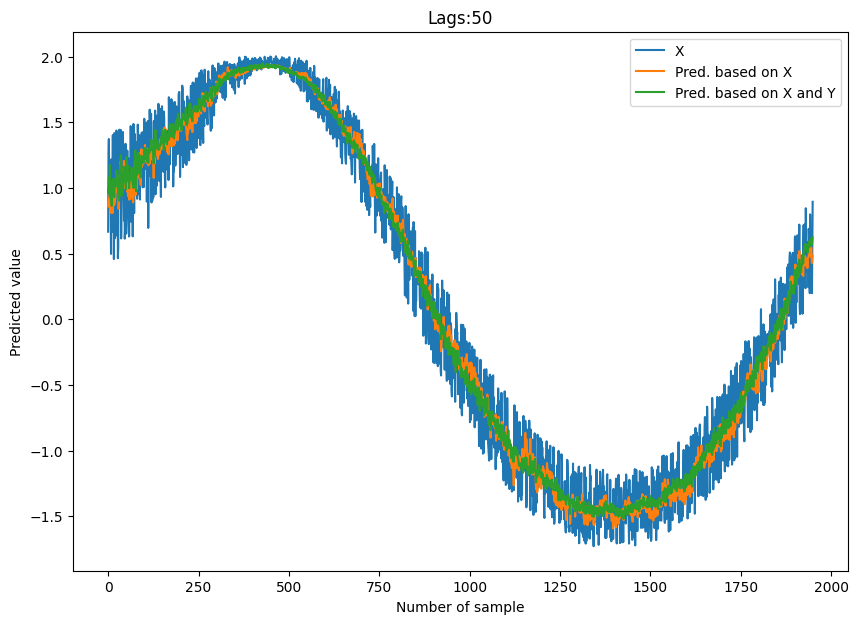

Statistics value = 1099413.0 p-value = 1.6802747241548963e-26


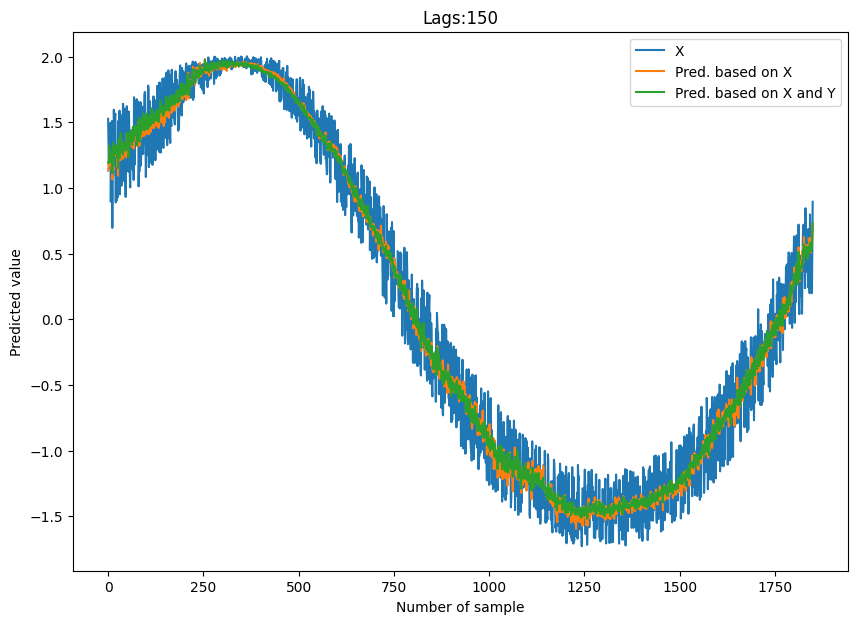

In [ ]:
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 9449.0 p-value = 0.3566899541578241


/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


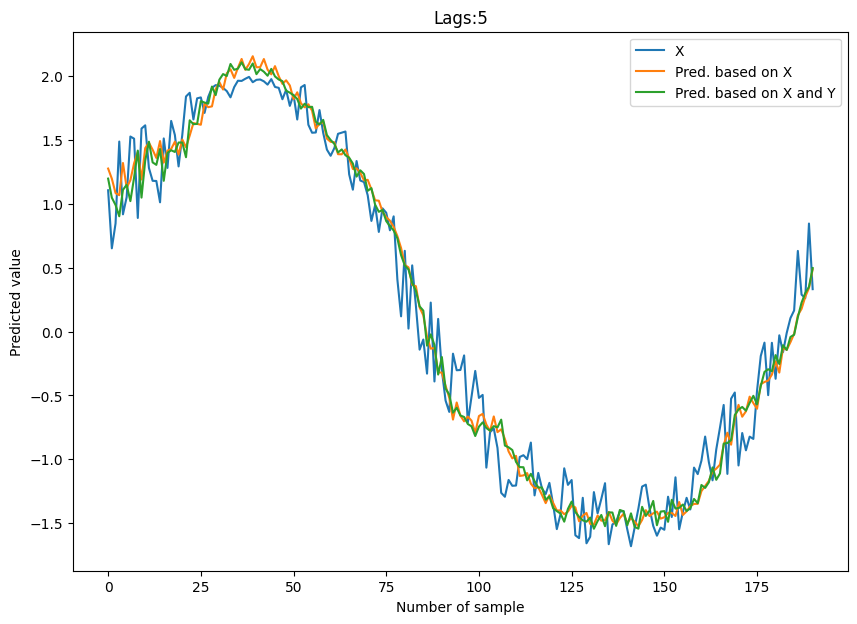

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 8785.0 p-value = 0.013597302548135959


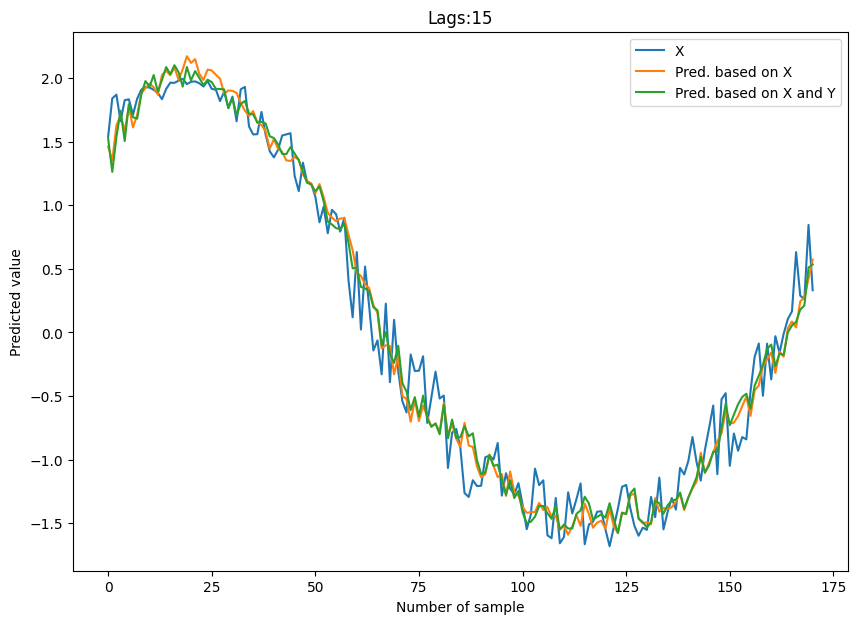

In [ ]:
#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])